In [1]:
%matplotlib inline

import json
import glob
import re
import itertools
import functools

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm

/Users/cimprich/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
mpl.rc('font', family='Arial', size=12)
mpl.rc('text', usetex=False)

In [3]:
with open('../../pair_counts.json') as f:
    read_pairs = json.load(f)
million_mapped = {k: v/2e6 for k, v in read_pairs.items()}
with open('../../mean_spikein_counts.json', 'r') as f:
    mean_spike_counts = json.load(f)

In [4]:
used_regions = pd.read_csv('../../natural_timecourse/genes_with_drip_peak.bed', sep='\t',
                           names = ('chr', 'start', 'end', 'name', 'value', 'strand')
                          )

In [5]:
associated_peaks = pd.read_csv('../../natural_timecourse/genes_and_drip_peaks_together.bed', sep='\t',
                            names = ('chr_gene', 'start_gene', 'end_gene', 'name_gene', 'expr', 'strand_gene',
                                     'chr_peak', 'start_peak', 'end_peak', 'x', 'y', 'strand_peak', 'overlap'
                                    ),
                            usecols = ('chr_gene', 'start_gene', 'end_gene', 'name_gene', 'expr', 'strand_gene',
                                       'chr_peak', 'start_peak', 'end_peak', 'strand_peak', 'overlap'
                                      )
                           )

In [6]:
associated_peaks.head()

,chr_gene,start_gene,end_gene,name_gene,expr,strand_gene,chr_peak,start_peak,end_peak,strand_peak,overlap
0,chr1,1324766,1328897,ENST00000343938.8,146,+,chr1,1328847,1337532,-,50
1,chr1,1331313,1335306,ENST00000339381.5,37,+,chr1,1328847,1337532,-,3993
2,chr1,1335275,1349112,ENST00000378891.9,493,-,chr1,1328847,1337532,-,2257
3,chr1,1785284,1891117,ENST00000610897.4,2382,-,chr1,1829772,1830294,-,522
4,chr1,1785284,1891117,ENST00000610897.4,2382,-,chr1,1856627,1858640,-,2013


In [7]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str).str.cat(df.strand, sep=';'), sep='-'), sep=':')


In [8]:
used_regions['ucsc_name'] = ucsc_index(used_regions)

In [9]:
{i:i.replace('_gene', '') for i in associated_peaks.columns}

{'chr_gene': 'chr',
 'chr_peak': 'chr_peak',
 'end_gene': 'end',
 'end_peak': 'end_peak',
 'expr': 'expr',
 'name_gene': 'name',
 'overlap': 'overlap',
 'start_gene': 'start',
 'start_peak': 'start_peak',
 'strand_gene': 'strand',
 'strand_peak': 'strand_peak'}

In [10]:
associated_peaks['ucsc_index'] = ucsc_index(associated_peaks.rename(columns={i:i.replace('_gene', '') for i in associated_peaks.columns}))

In [11]:
region_mask = pd.read_hdf('region_mask.hdf')

(array([  0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,
          2.,   0.,   1.,   0.,   0.,   2.,   1.,   0.,   1.,   2.,   2.,
          0.,   1.,   2.,   5.,   1.,   0.,   2.,   1.,   2.,   4.,   4.,
          2.,   5.,   5.,   6.,   4.,   7.,   5.,   6.,   8.,   8.,   7.,
          7.,   6.,  17.,  10.,   5.,  11.,  14.,  18.,  19.,  19.,  18.,
         23.,  20.,  20.,  22.,  41.,  32.,  36.,  45.,  66.,  57.,  65.,
         86.,  86., 103., 123., 153., 198., 259., 225., 333., 437., 864.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48

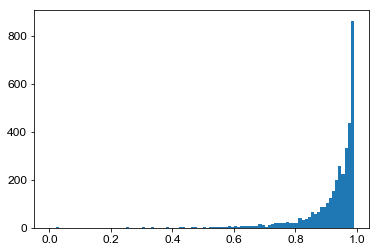

In [12]:
fig,ax=plt.subplots()
ax.hist(region_mask.isna().mean(axis=1), bins=np.arange(0, 1.0, 0.01))

# Load data

In [13]:
def read_matrix_file(f):
    temp = pd.read_csv(f, compression='gzip', comment='@', sep='\t', header=None)
    # Generate a UCSC style description of the peak coordinates
    ucsc_idx = (temp.iloc[:, 0].str.cat(
                    temp.iloc[:, 1].astype(str).str.cat(
                        temp.iloc[:, 2].astype(str).str.cat( 
                            temp.iloc[:, 5].astype(str), sep = ';'),
                    sep= '-'), 
                sep=':'))
    # Drop the first 6 columns, which here act as a descriptor
    temp = temp.set_index(ucsc_idx).drop(range(6), axis=1).fillna(0)
    temp.columns = temp.columns - 6
    return temp

In [14]:
def load_from_directory(directory, file_ext = 'temp'):
    file_extractor = re.compile(f'/([^/]+)\.([mp]){file_ext}')
    data = {}
    for file in glob.glob(f'{directory}/*{file_ext}'):
        data[file_extractor.findall(file)[0]] = read_matrix_file(file)
    return data

In [15]:
raw_data = load_from_directory('../../natural_timecourse/overlaps/')

In [16]:
raw_data.keys()

dict_keys([('dmso_2', 'm'), ('dmso_2', 'p'), ('dmso_3', 'm'), ('dmso_3', 'p'), ('dmso_in', 'm'), ('dmso_in', 'p'), ('drb_2', 'm'), ('drb_2', 'p'), ('drb_3', 'm'), ('drb_3', 'p'), ('drb_in', 'm'), ('drb_in', 'p'), ('drb_rh', 'm'), ('drb_rh', 'p')])

In [17]:
def seperate_sense_antisense(raw_data):
    sense_data = {k[0]: v.copy() for k,v in raw_data.items() if k[1] == 'm'}
    antisense_data = {k[0]: v.copy() for k,v in raw_data.items() if k[1] == 'p'}
    for sample_name, mat in sense_data.items():
        mat.loc[mat.index.str.contains(';-'), :] = raw_data[(sample_name, 'p')].loc[mat.index.str.contains(';-'), :]
    for sample_name, mat in antisense_data.items():
        mat.loc[mat.index.str.contains(';-'), :] = raw_data[(sample_name, 'm')].loc[mat.index.str.contains(';-'), :]
    return sense_data, antisense_data

In [18]:
sense, antisense = seperate_sense_antisense(raw_data)

# Analysis with spikeins 

In [19]:
mean_dmso = (sense['dmso_2']/mean_spike_counts['dmso_2'] + 
             sense['dmso_3']/mean_spike_counts['dmso_3'])/2
mean_drb = (sense['drb_2']/mean_spike_counts['drb_2'] + 
             sense['drb_3']/mean_spike_counts['drb_3'])/2

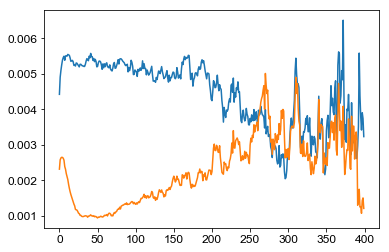

In [20]:
plt.plot(np.nanmean(mean_dmso * region_mask, axis=0))
plt.plot(np.nanmean(mean_drb * region_mask, axis=0))

In [21]:
pct_remaining = mean_drb / mean_dmso

In [22]:
pct_remaining[pct_remaining == np.inf] = np.nan
pct_remaining[pct_remaining == -np.inf] = np.nan

In [23]:
def bootstrap_samples(mat, n_samples, agg_func = np.mean, verbose=False, sample_name = ''):
    agg_func = functools.partial(agg_func, axis=0)
    boot_samples = np.empty((n_samples, mat.shape[1]), dtype=np.float32)
    for i in range(n_samples):
        if verbose and not i % (n_samples // 25):
            print(sample_name, (i / n_samples) * 100)
        boot_samples[i, :] = agg_func(mat[np.random.choice(len(mat), len(mat), replace=True), :])
    return boot_samples

In [24]:
filtered_data = (pct_remaining * region_mask)

In [25]:
filtered_data = filtered_data.loc[filtered_data.isna().sum(axis=1) < 400, :]

In [26]:
boot_samples = bootstrap_samples((filtered_data).as_matrix(),
                                 10000, 
                                 agg_func=np.nanmean, 
                                 verbose=True, 
                                 sample_name= 'DMSO_vs_DRB')

DMSO_vs_DRB 0.0


/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


DMSO_vs_DRB 4.0
DMSO_vs_DRB 8.0
DMSO_vs_DRB 12.0
DMSO_vs_DRB 16.0
DMSO_vs_DRB 20.0
DMSO_vs_DRB 24.0
DMSO_vs_DRB 28.000000000000004
DMSO_vs_DRB 32.0
DMSO_vs_DRB 36.0
DMSO_vs_DRB 40.0
DMSO_vs_DRB 44.0
DMSO_vs_DRB 48.0
DMSO_vs_DRB 52.0
DMSO_vs_DRB 56.00000000000001
DMSO_vs_DRB 60.0
DMSO_vs_DRB 64.0
DMSO_vs_DRB 68.0
DMSO_vs_DRB 72.0
DMSO_vs_DRB 76.0
DMSO_vs_DRB 80.0
DMSO_vs_DRB 84.0
DMSO_vs_DRB 88.0
DMSO_vs_DRB 92.0
DMSO_vs_DRB 96.0


In [27]:
def mean_95_ci(ax, mat, x = None, color='blue'):
    if x is None:
        x = np.arange(0, mat.shape[1], 1)
    ax.plot(x, mat.mean(axis=0), color=color)
    ax.fill_between(x, 
                    np.percentile(mat, 2.5, axis=0), 
                    np.percentile(mat, 97.5, axis=0),
                    alpha = 0.5, color=color)

/Users/cimprich/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Text(0.5,0,'')

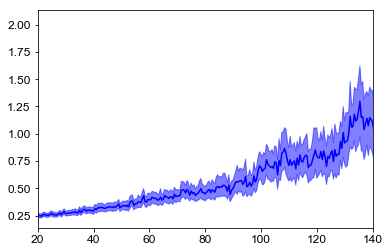

In [28]:
fig, ax = plt.subplots()

mean_95_ci(ax, boot_samples, x=np.arange(0, 200, 0.5))
ax.set_xlim(20, 140)
#ax.set_ylim(0, 1)
ax.set_xlabel('')

In [29]:
raw_data = pd.melt((pct_remaining * region_mask).reset_index(), id_vars = 'index').dropna()

(0, 1)

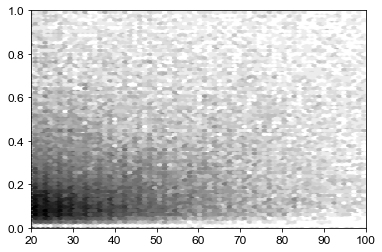

In [30]:
fig, ax = plt.subplots()

mask = (raw_data.variable > 40) & (raw_data.variable < 280) & ( raw_data.value < 1)

ax.hexbin(raw_data.variable[mask] / 2, raw_data.value[mask], bins='log', cmap='Greys')
ax.set_xlim(20, 100)
ax.set_ylim(0, 1)

# Use exact transcription rates

In [31]:
transcription_rates = pd.read_csv('elongation_rates.csv')
gene_data = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg38/hg38_cannonical_GENCODE_v29_symbols.tsv', sep='\t',
                        names = ('transcript_id', 'name', 'gencode_2', 'chr', 'strand', 'start', 'end', 
                                 'cd_start', 'cd_end', 'exon_count', 'exon_starts', 'exon_ends', 'prot_id', 'align_id'),
                        usecols = ('chr', 'start', 'end', 'strand', 'name', 'align_id', 'transcript_id'), header = 0
                       )
gene_data['ucsc_name'] = ucsc_index(gene_data)
transcription_rates = transcription_rates.merge(gene_data[['name', 'transcript_id', 'ucsc_name']])

In [32]:
filtered_regions = used_regions.set_index('ucsc_name').loc[list(filtered_data.index), :]
filtered_regions = filtered_regions.merge(transcription_rates[['transcript_id', 'Velocity', 'Confidence Interval']].rename(columns = {'transcript_id': 'name', 
                                                                                                                   'Velocity': 'velocity', 
                                                                                                                   'Confidence Interval': 'confidence_interval'}),
                       
                      
                      )
filtered_regions['ucsc_name'] = ucsc_index(filtered_regions)

In [33]:
data_with_txn_rates = filtered_data.loc[filtered_regions.ucsc_name, :]

In [34]:
boot_samples = bootstrap_samples((data_with_txn_rates).as_matrix(),
                                 #10000,
                                 2000, 
                                 agg_func=np.nanmean, 
                                 verbose=True, 
                                 sample_name= 'DMSO_vs_DRB')

DMSO_vs_DRB 0.0
DMSO_vs_DRB 4.0
DMSO_vs_DRB 8.0
DMSO_vs_DRB 12.0


/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


DMSO_vs_DRB 16.0
DMSO_vs_DRB 20.0
DMSO_vs_DRB 24.0
DMSO_vs_DRB 28.000000000000004
DMSO_vs_DRB 32.0
DMSO_vs_DRB 36.0
DMSO_vs_DRB 40.0
DMSO_vs_DRB 44.0
DMSO_vs_DRB 48.0
DMSO_vs_DRB 52.0
DMSO_vs_DRB 56.00000000000001
DMSO_vs_DRB 60.0
DMSO_vs_DRB 64.0
DMSO_vs_DRB 68.0
DMSO_vs_DRB 72.0
DMSO_vs_DRB 76.0
DMSO_vs_DRB 80.0
DMSO_vs_DRB 84.0
DMSO_vs_DRB 88.0
DMSO_vs_DRB 92.0
DMSO_vs_DRB 96.0


/Users/cimprich/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Text(0.5,0,'')

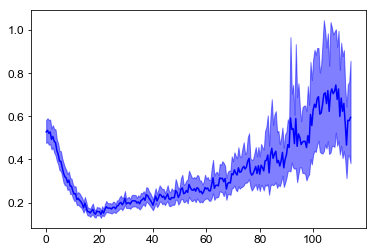

In [35]:
fig, ax = plt.subplots()

mean_95_ci(ax, boot_samples, x=np.arange(0, 200, 0.5))
ax.set_xlabel('')

In [36]:
time_without_txn = pd.melt((pct_remaining * region_mask).reset_index(), id_vars = 'index').dropna()
time_without_txn = time_without_txn.rename(columns = {'index':'ucsc_name', 'variable': 'distance_from_tss'}).merge(filtered_regions[['ucsc_name', 'velocity']])
time_without_txn['distance_from_tss'] = pd.to_numeric(time_without_txn['distance_from_tss'])
time_without_txn['distance_from_tss'] = time_without_txn.distance_from_tss * 0.5

In [37]:
time_without_txn['transcription_front'] = 40 * time_without_txn.velocity

In [38]:
time_without_txn['est_time'] = (time_without_txn.transcription_front - time_without_txn.distance_from_tss)/(time_without_txn.velocity)

In [39]:
within_limits = ((time_without_txn.distance_from_tss >= 20) & (time_without_txn.est_time > 0))

In [40]:
time_without_txn['time_bin'] = pd.cut(time_without_txn.est_time, np.arange(0, 45, 0.5))

In [41]:
reshaped = (time_without_txn[within_limits]
      .groupby(['ucsc_name',
                pd.cut(time_without_txn[within_limits].est_time, 
                       np.arange(0, 45, 0.5))
               ]
              )
      .value
      .mean()
      .unstack()
     )

In [42]:
reshaped.head()

est_time,"(0.0, 0.5]","(0.5, 1.0]","(1.0, 1.5]","(1.5, 2.0]","(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]","(4.0, 4.5]","(4.5, 5.0]",...,"(33.0, 33.5]","(33.5, 34.0]","(34.0, 34.5]","(34.5, 35.0]","(35.0, 35.5]","(35.5, 36.0]","(36.0, 36.5]","(36.5, 37.0]","(37.0, 37.5]","(37.5, 38.0]"
ucsc_name,,,,,,,,,,,,,,,,,,,,,
chr10:100188297-100229619;-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr10:102776248-102816267;+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr10:112374017-112428376;+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr10:118297929-118342320;-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.060265,0.064599,0.074368,0.113739,NaN,NaN,NaN,NaN,NaN,NaN
chr10:119892710-119944658;+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.102391,0.203018,0.145792,0.175579,0.322779,NaN,NaN,NaN,NaN,NaN


In [43]:
boot_samples = bootstrap_samples((reshaped).as_matrix(),
                                 #10000, 
                                 5000, 
                                 agg_func=np.nanmean, 
                                 verbose=True, 
                                 sample_name= 'DMSO_vs_DRB')

DMSO_vs_DRB 0.0
DMSO_vs_DRB 4.0
DMSO_vs_DRB 8.0
DMSO_vs_DRB 12.0
DMSO_vs_DRB 16.0


/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


DMSO_vs_DRB 20.0
DMSO_vs_DRB 24.0
DMSO_vs_DRB 28.000000000000004
DMSO_vs_DRB 32.0
DMSO_vs_DRB 36.0
DMSO_vs_DRB 40.0
DMSO_vs_DRB 44.0
DMSO_vs_DRB 48.0
DMSO_vs_DRB 52.0
DMSO_vs_DRB 56.00000000000001
DMSO_vs_DRB 60.0
DMSO_vs_DRB 64.0
DMSO_vs_DRB 68.0
DMSO_vs_DRB 72.0
DMSO_vs_DRB 76.0
DMSO_vs_DRB 80.0
DMSO_vs_DRB 84.0
DMSO_vs_DRB 88.0
DMSO_vs_DRB 92.0
DMSO_vs_DRB 96.0


In [44]:
def mean_95_ci_na(ax, mat, x = None, color='blue', alpha=0.5):
    if x is None:
        x = np.arange(0, mat.shape[1], 1)
    ax.plot(x, np.nanmean(mat, axis=0), color=color)
    ax.fill_between(x, 
                    np.nanpercentile(mat, 2.5, axis=0), 
                    np.nanpercentile(mat, 97.5, axis=0),
                    alpha = alpha, color=color)

In [45]:
highly_represented_data = reshaped.loc[reshaped.loc[(reshaped.notnull().sum(axis=1) >= 20), :].index, :]

In [46]:
boot_high_repr = bootstrap_samples((highly_represented_data).as_matrix(),
                                 10000, 
                                 agg_func=np.nanmean, 
                                 verbose=True, 
                                 sample_name= 'DMSO_vs_DRB')

DMSO_vs_DRB 0.0
DMSO_vs_DRB 4.0
DMSO_vs_DRB 8.0
DMSO_vs_DRB 12.0
DMSO_vs_DRB 16.0


/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


DMSO_vs_DRB 20.0
DMSO_vs_DRB 24.0
DMSO_vs_DRB 28.000000000000004
DMSO_vs_DRB 32.0
DMSO_vs_DRB 36.0
DMSO_vs_DRB 40.0
DMSO_vs_DRB 44.0
DMSO_vs_DRB 48.0
DMSO_vs_DRB 52.0
DMSO_vs_DRB 56.00000000000001
DMSO_vs_DRB 60.0
DMSO_vs_DRB 64.0
DMSO_vs_DRB 68.0
DMSO_vs_DRB 72.0
DMSO_vs_DRB 76.0
DMSO_vs_DRB 80.0
DMSO_vs_DRB 84.0
DMSO_vs_DRB 88.0
DMSO_vs_DRB 92.0
DMSO_vs_DRB 96.0


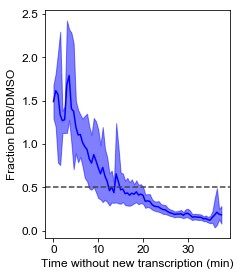

In [47]:
fig, ax = plt.subplots(figsize=(3.5,4))

mean_95_ci_na(ax, boot_high_repr, x = np.arange(0, 38, 0.5))
ax.axhline(0.5, color = '#444444', linestyle='--')
ax.set_xlabel('Time without new transcription (min)')
ax.set_ylabel('Fraction DRB/DMSO')
fig.tight_layout()
fig.savefig('Lifetimes_genes_with_many_data_points.pdf', transparent=True)
fig.savefig('Lifetimes_genes_with_many_data_points.svg', transparent=True)

In [48]:
np.where(np.nanmean(boot_samples, axis=0) < 0.5)

(array([27, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
        66, 67, 68, 69, 70, 71, 72, 73, 74, 75]),)

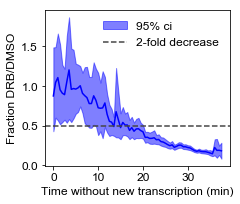

In [49]:
fig, ax = plt.subplots(figsize=(3.5,3))

mean_95_ci_na(ax, boot_samples, x = np.arange(0, 38, 0.5))
ax.axhline(0.5, color = '#444444', linestyle='--', label='mean')
ax.set_xlabel('Time without new transcription (min)')
ax.set_ylabel('Fraction DRB/DMSO')
handles = [
    mpl.patches.Patch(color = 'blue', alpha = 0.5),
    mpl.lines.Line2D([0], [0], color = '#444444', linestyle='--')
]
labels = ['95% ci', '2-fold decrease']
ax.legend(handles=handles, labels=labels, frameon=False)
fig.tight_layout()
fig.savefig('Mean_lifetimes.pdf', transparent=True)
fig.savefig('Mean_lifetimes.svg', transparent=True)

# Fit individual lifetimes

In [50]:
data_to_fit = reshaped.loc[reshaped.loc[(reshaped.notnull().sum(axis=1) >= 5), :].index, :]

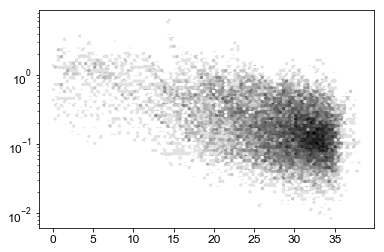

In [51]:
fig, ax = plt.subplots()

mask = (within_limits & 
        (time_without_txn.value > 0) & 
        time_without_txn.ucsc_name.isin(data_to_fit.index))

ax.hexbin( time_without_txn.loc[mask, 'est_time'],
          time_without_txn.loc[mask, 'value'],
          bins = 'log', cmap = 'Greys', yscale='log'
         )


In [52]:
a_coef = []
b_coef = []
x = np.array([i.left for i in data_to_fit.columns])
for region_name, gene_data in data_to_fit.iterrows():
    y = gene_data.copy()
    fit_mask = np.isfinite(np.log10(y))
    if fit_mask.sum() == 0:
        a,b = np.nan, np.nan
    else:
        a, b = np.polyfit(x[fit_mask], np.log(y)[fit_mask], 1, w = np.sqrt(x[fit_mask]))
    a_coef.append(a)
    b_coef.append(b)

/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [53]:
a_coef = {}
rsq = {}
x = np.array([i.left for i in data_to_fit.columns])
for region_name, gene_data in data_to_fit.iterrows():
    y = gene_data.copy()
    fit_mask = np.isfinite(np.log10(y))
    if fit_mask.sum() == 0:
        a,b = np.nan, np.nan
    else:
        mod = sm.OLS(np.log(y[fit_mask]), x[fit_mask], weights=np.sqrt(x[fit_mask]))
        mod_linear = sm.OLS(y[fit_mask], x[fit_mask])
        res = mod.fit()
        res_linear = mod_linear.fit()
        if res.rsquared > 0.95:
            a = res.params['x1']
        else: 
            a = np.nan
    a_coef[region_name] = a
    rsq[region_name] = {'linear': res_linear.rsquared, 'exponential': res.rsquared}
models = pd.DataFrame(rsq).T

/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


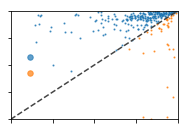

In [54]:
fig, ax = plt.subplots(figsize=(3,2))
greater_mask = models.exponential > models.linear
ax.scatter(models[greater_mask].linear, models[greater_mask].exponential, 
           label = 'Better exponential', s=1.2, alpha=0.7)
ax.scatter(models[~greater_mask].linear, models[~greater_mask].exponential,
           label = 'Better linear', s=1.2, alpha=0.7)
ax.plot([0,1],[0,1], color = '#444444', linestyle='--')
handles, _ = ax.get_legend_handles_labels()
ax.legend(labels = ['', ''], handles = handles[0:2], frameon=False, markerscale=5, borderpad=0.1)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xticklabels(['']*3)
ax.set_yticklabels(['']*3)
fig.savefig('Model_selection.svg')

In [55]:
(models.linear <= models.exponential).sum()

224

In [56]:
(models.linear > models.exponential).sum()

38

(0, 1.5)

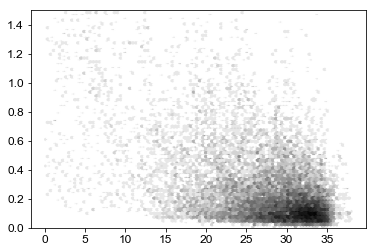

In [57]:
fig, ax = plt.subplots()

mask = (within_limits & 
        (time_without_txn.value > 0) & 
        (time_without_txn.value < 1.5) &
        time_without_txn.ucsc_name.isin(data_to_fit.index))

ax.hexbin( time_without_txn.loc[mask, 'est_time'],
          time_without_txn.loc[mask, 'value'],
          bins = 'log', cmap = 'Greys'
         )

ax.set_ylim(0, 1.5)


In [58]:
cmap = plt.get_cmap('RdBu')

TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U27') dtype('<U27') dtype('<U27')

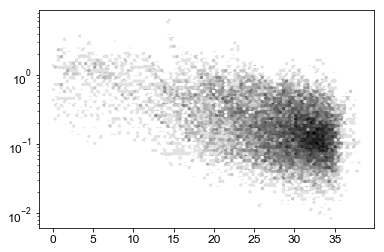

In [59]:
fig, ax = plt.subplots()
plt.set_cmap('RdBu')
mask = (within_limits & 
        (time_without_txn.value > 0) & 
        time_without_txn.ucsc_name.isin(data_to_fit.index))

ax.hexbin( time_without_txn.loc[mask, 'est_time'],
          time_without_txn.loc[mask, 'value'],
          bins = 'log', cmap = 'Greys', yscale='log'
         )

line_range = np.arange(0, 38)

for a,b in zip(a_coef, b_coef):
    ax.plot(line_range, 10**(a*line_range + b), alpha=0.1, color=cmap(a))

In [64]:
half_lives = pd.Series(a_coef).dropna()
half_lives = -np.log(2)/half_lives

In [65]:
len(half_lives)

107

In [66]:
half_lives[half_lives > 20]

chr12:95473950-95515839;+     20.084354
chr6:30234038-30326134;-      21.387580
chr7:102749027-102808840;+    24.815912
dtype: float64

In [67]:
half_lives.nlargest(10)

chr7:102749027-102808840;+    24.815912
chr6:30234038-30326134;-      21.387580
chr12:95473950-95515839;+     20.084354
chr20:62238484-62296213;+     19.336247
chr19:52297176-52325922;+     18.172507
chr18:14103862-14132430;-     16.777620
chr5:134758803-134829296;+    15.887252
chr16:21599475-21657473;+     15.563646
chr11:63624086-63671612;-     15.341733
chr15:41417103-41483563;+     14.127761
dtype: float64

In [68]:
half_lives.mean(), half_lives.std()

(11.003628001309124, 3.102079425748964)

In [69]:
((half_lives - 11).abs() < 4).mean()

0.8878504672897196

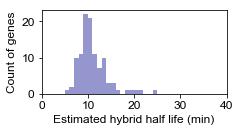

In [70]:
fig, ax = plt.subplots(figsize=(3.5,2))
plt.hist(half_lives, bins = np.arange(0, 100, 1), color='#9696cf', label='Half lives')
#ax.axvline(half_lives[((half_lives < 120) & (half_lives > 0))].mean(), 
#           color = '#444444', linestyle = '--', label = 'Mean half life')
ax.set_ylabel('Count of genes')
ax.set_xlabel('Estimated hybrid half life (min)')
ax.set_xlim(0, 40)
#ax.legend(frameon=False, borderpad=0.3, labelspacing=0.2)
fig.tight_layout()
fig.savefig('Half_life_distribution.svg', transparent=True)

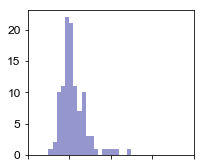

In [71]:
fig, ax = plt.subplots(figsize=(3,2.5))
plt.hist(half_lives, bins = np.arange(0, 100, 1), color='#9696cf', label='Half lives')
#ax.axvline(half_lives[((half_lives < 120) & (half_lives > 0))].mean(), 
#           color = '#444444', linestyle = '--', label = 'Mean half life')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_xlim(0, 40)
#ax.legend(frameon=False, borderpad=0.3, labelspacing=0.2)
fig.tight_layout()
#fig.savefig('Half_life_distribution.svg', transparent=True)

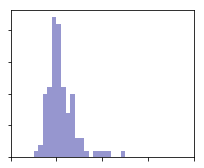

In [72]:
fig, ax = plt.subplots(figsize=(3,2.5))
plt.hist(half_lives, bins = np.arange(0, 100, 1), color='#9696cf', label='Half lives')
#ax.axvline(half_lives[((half_lives < 120) & (half_lives > 0))].mean(), 
#           color = '#444444', linestyle = '--', label = 'Mean half life')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_xlim(0, 40)
#ax.legend(frameon=False, borderpad=0.3, labelspacing=0.2)
fig.tight_layout()
fig.savefig('Half_life_distribution.svg', transparent=True)

# Isolate faster/slower areas

In [73]:
profile_data = pd.DataFrame({
    'mean_per_bin': pd.Series(np.nanmean(reshaped, axis=0), index = reshaped.columns),
    'stdev_per_bin': pd.Series(np.nanstd(reshaped, axis=0), index = reshaped.columns)
})

In [74]:
time_without_txn = time_without_txn.merge(profile_data,
                       right_index=True, 
                       left_on='time_bin', 
                       how ='left')

In [75]:
time_without_txn['speed_compared_to_avg'] = np.nan
time_without_txn['z_score'] = (time_without_txn.value - time_without_txn.mean_per_bin)/time_without_txn.stdev_per_bin
slower_than_avg = (time_without_txn.value > (time_without_txn.mean_per_bin +  time_without_txn.stdev_per_bin))
faster_than_avg = (time_without_txn.value < (time_without_txn.mean_per_bin  - time_without_txn.stdev_per_bin))
ns = ((time_without_txn.mean_per_bin  - time_without_txn.value).abs() < time_without_txn.stdev_per_bin)
time_without_txn.loc[slower_than_avg, 'speed_compared_to_avg'] = 'slower'
time_without_txn.loc[faster_than_avg, 'speed_compared_to_avg'] = 'faster'
time_without_txn.loc[ns, 'speed_compared_to_avg'] = 'ns'

In [76]:
time_without_txn.speed_compared_to_avg.value_counts()

ns        15330
slower     3002
faster     1641
Name: speed_compared_to_avg, dtype: int64

In [77]:
time_without_txn.head()

,ucsc_name,distance_from_tss,value,velocity,transcription_front,est_time,time_bin,mean_per_bin,stdev_per_bin,speed_compared_to_avg,z_score
0,chr10:118297929-118342320;-,0.0,0.195874,3.6375,145.5,40.000000,"(39.5, 40.0]",NaN,NaN,NaN,NaN
1,chr10:118297929-118342320;-,0.5,0.225174,3.6375,145.5,39.862543,"(39.5, 40.0]",NaN,NaN,NaN,NaN
2,chr10:118297929-118342320;-,1.0,0.215297,3.6375,145.5,39.725086,"(39.5, 40.0]",NaN,NaN,NaN,NaN
3,chr10:118297929-118342320;-,1.5,0.303928,3.6375,145.5,39.587629,"(39.5, 40.0]",NaN,NaN,NaN,NaN
4,chr10:118297929-118342320;-,2.0,0.534973,3.6375,145.5,39.450172,"(39.0, 39.5]",NaN,NaN,NaN,NaN


In [78]:
correlation_regions = time_without_txn.loc[time_without_txn.speed_compared_to_avg.notnull(), ['ucsc_name', 'distance_from_tss', 'value', 'speed_compared_to_avg', 
                                                                                              'est_time', 'z_score']]
coords = (correlation_regions
          .ucsc_name
          .str.extract('(.*):(\d+)-(\d+);([-+])', expand=True)
          .rename(columns = dict(zip(range(4), ['chr', 'start', 'end', 'strand'])))
         )
correlation_regions = correlation_regions.join(coords)

In [79]:
correlation_regions.start = pd.to_numeric(correlation_regions.start)
correlation_regions.end = pd.to_numeric(correlation_regions.end)

In [80]:
correlation_regions['region_start'] = np.nan
correlation_regions['region_end'] = np.nan
correlation_regions.loc[correlation_regions.strand == '+', 'region_start'] = (correlation_regions.loc[correlation_regions.strand == '+', 'start'] + 
                                                                              1000 * correlation_regions.loc[correlation_regions.strand == '+', 'distance_from_tss'])
correlation_regions.loc[correlation_regions.strand == '+', 'region_end'] = correlation_regions.loc[correlation_regions.strand == '+', 'region_start'] + 500

correlation_regions.loc[correlation_regions.strand == '-', 'region_start'] = (correlation_regions.loc[correlation_regions.strand == '-', 'end'] - 
                                                                              1000 * (correlation_regions.loc[correlation_regions.strand == '-', 'distance_from_tss'] + 0.5))
correlation_regions.loc[correlation_regions.strand == '-', 'region_end'] = correlation_regions.loc[correlation_regions.strand == '-', 'region_start'] + 500

In [81]:
correlation_regions.region_end = correlation_regions.region_end.astype(int)
correlation_regions.region_start = correlation_regions.region_start.astype(int)

In [84]:
correlation_regions.to_hdf('region_data.hdf', key='region_data')

In [76]:
(correlation_regions.loc[:, 
                    ['chr', 'region_start', 'region_end', 'ucsc_name', 'speed_compared_to_avg', 'strand']]
 .to_csv('regions_speed.bed', sep='\t', index=False, header=False))

In [77]:
!head regions_speed.bed

chr10	118334320	118334820	chr10:118297929-118342320;-	ns	-
chr10	118333820	118334320	chr10:118297929-118342320;-	ns	-
chr10	118333320	118333820	chr10:118297929-118342320;-	ns	-
chr10	118332820	118333320	chr10:118297929-118342320;-	faster	-
chr10	118332320	118332820	chr10:118297929-118342320;-	slower	-
chr10	118331820	118332320	chr10:118297929-118342320;-	slower	-
chr10	118331320	118331820	chr10:118297929-118342320;-	faster	-
chr10	118330820	118331320	chr10:118297929-118342320;-	ns	-
chr10	118330320	118330820	chr10:118297929-118342320;-	ns	-
chr10	118329820	118330320	chr10:118297929-118342320;-	ns	-


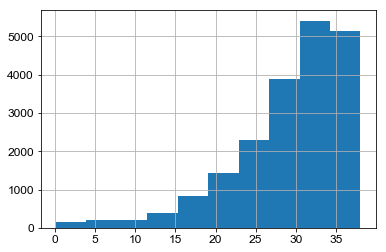

In [78]:
correlation_regions.est_time.hist()

In [126]:
extreme_vals = correlation_regions[((correlation_regions.est_time - 25).abs() < 1) &
                              (correlation_regions.z_score.abs() > 1) & 
                              (correlation_regions.value < 1.1)
                           ]

non_extreme_vals = correlation_regions[((correlation_regions.est_time - 25).abs() < 1) &
                              (correlation_regions.z_score.abs() < 0.1) & 
                              (correlation_regions.value < 1.1)
                           ]

extreme_vals_17 = correlation_regions[((correlation_regions.est_time - 23).abs() < 1) &
                              (correlation_regions.z_score.abs() > 1) & 
                              (correlation_regions.value < 1.1)
                           ]


non_extreme_vals_17 = correlation_regions[((correlation_regions.est_time - 23).abs() < 1) &
                              (correlation_regions.z_score.abs() < 0.1) & 
                              (correlation_regions.value < 1.1)
                           ]

In [116]:
extreme_vals.sort_values('z_score').head()

,ucsc_name,distance_from_tss,value,speed_compared_to_avg,est_time,z_score,chr,start,end,strand,region_start,region_end
19318,chr5:57174116-57263082;+,53.0,0.0,faster,24.411765,-1.266392,chr5,57174116,57263082,+,57227116,57227616
16199,chr8:109240918-109334385;-,56.0,0.0,faster,25.033409,-1.215870,chr8,109240918,109334385,-,109277885,109278385
8836,chr4:143513462-143557486;+,40.5,0.0,faster,25.470852,-1.215870,chr4,143513462,143557486,+,143553962,143554462
19808,chr1:94171750-94237565;-,58.0,0.0,faster,25.016145,-1.215870,chr1,94171750,94237565,-,94179065,94179565
20041,chr1:212736955-212791782;-,43.0,0.0,faster,25.706370,-1.206734,chr1,212736955,212791782,-,212748282,212748782


In [117]:
extreme_vals.sort_values('z_score').tail()

,ucsc_name,distance_from_tss,value,speed_compared_to_avg,est_time,z_score,chr,start,end,strand,region_start,region_end
21508,chr1:229440259-229508341;-,59.5,0.973920,slower,25.819264,3.259846,chr1,229440259,229508341,-,229448341,229448841
8345,chr3:152268039-152465779;+,155.5,1.084948,slower,24.051282,3.290669,chr3,152268039,152465779,+,152423539,152424039
8311,chr3:152268039-152465779;+,138.5,1.011034,slower,25.794872,3.430058,chr3,152268039,152465779,+,152406539,152407039
8312,chr3:152268039-152465779;+,139.0,1.059364,slower,25.743590,3.651708,chr3,152268039,152465779,+,152407039,152407539
19066,chr9:94558719-94593793;-,26.5,1.063392,slower,25.929201,3.670183,chr9,94558719,94593793,-,94566793,94567293


In [118]:
def region_index(df):
    return df.chr.str.cat(df.region_start.astype(str).str.cat(df.region_end.astype(str), sep='-'), sep=':')


In [127]:
extreme_vals['region_index'] = region_index(extreme_vals)
non_extreme_vals['region_index'] = region_index(non_extreme_vals)
extreme_vals_17['region_index'] = region_index(extreme_vals_17)
non_extreme_vals_17['region_index'] = region_index(non_extreme_vals_17)

/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cimprich/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [120]:
extreme_vals.distance_from_tss.mean()
extreme_vals.distance_from_tss.mean()

67.35625

In [125]:

(extreme_vals.loc[(extreme_vals.distance_from_tss - 66) < 5, 
                 ['chr', 'region_start', 'region_end', 'region_index', 'value', 'strand']]
    .sort_values(['chr', 'region_start', 'region_end'])
    .to_csv('extreme_regions/regions_extreme.bed', sep='\t', index=False, header=False)
)

(non_extreme_vals.loc[(non_extreme_vals.distance_from_tss - 66) < 5, 
                 ['chr', 'region_start', 'region_end', 'region_index', 'value', 'strand']]
    .sort_values(['chr', 'region_start', 'region_end'])
    .to_csv('extreme_regions/regions_non_extreme.bed', sep='\t', index=False, header=False)
)

(extreme_vals_17.loc[(extreme_vals_17.distance_from_tss - 83) < 5, 
                 ['chr', 'region_start', 'region_end', 'region_index', 'value', 'strand']]
    .sort_values(['chr', 'region_start', 'region_end'])
    .to_csv('extreme_regions/regions_extreme_17.bed', sep='\t', index=False, header=False)
)

(non_extreme_vals_17.loc[(non_extreme_vals_17.distance_from_tss - 83) < 5, 
                 ['chr', 'region_start', 'region_end', 'region_index', 'value', 'strand']]
    .sort_values(['chr', 'region_start', 'region_end'])
    .to_csv('extreme_regions/regions_non_extreme_17.bed', sep='\t', index=False, header=False)
)